In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### `uncontrolled.csv` is from a run with a constant tolerance of 2 degrees. It serves as baseline data and is included in the repository for reference. If changes are made to the framework, it should be replaced or removed.

In [280]:
uncontrolled = pd.read_csv('uncontrolled_year.csv', index_col=0)
uncontrolled.index = pd.DatetimeIndex(uncontrolled.index.str.replace('PST|PDT', '', regex=True))

data = {
    'uncontrolled': 'data_uncontrolled',
    'power': 'gridlab-d',
    'tolerant': 'data_high_tol',
    'opportune': 'data_opportune'
}
prices = pd.DataFrame({})

for case, path in data.items():
    power = pd.read_csv(f'{path}/power_log.csv', skiprows = 7, index_col = 0)
    power.index.name = power.index.name.replace('# ', '')
    power.columns = power.columns.str.replace(':measured_real_power', '')
    power.index = pd.DatetimeIndex(power.index.str.replace('PST|PDT', '', regex=True))
    data[case] = power/1e3

    _price = pd.read_csv(f'{path}/price_log.csv')
    price = _price[::3]['price']
    prices[f'{case}'] = list(price)

prices.index = pd.DatetimeIndex(data['uncontrolled'].index.copy())

#print(power['N2'].mean())
#print(power['N2'].std())
temp_df = data['uncontrolled'].index
month_index = [0]
for m in range(2,13):
    month = f'2000-{m:02d}-01 00:00:00'
    #if m < 10:
    #    month = f'2000-0{m}-01 00:00:00'
    #else:
    #    month = f'2000-{m}-01 00:00:00'
    month_index.append(temp_df.get_loc(month))


In [8]:
#avgs = [x + ': ' + str(uncontrolled[x].mean()) for x in uncontrolled]

means_lists = {}
for node in data['uncontrolled'].columns:
    node_data = data['uncontrolled'][node]
    mean_data = []
    std_data = []
    for i in range(0, len(month_index)-1):
        current = node_data[month_index[i]:month_index[i+1]]
        mean_data.append(current.mean())
        std_data.append(current.std())
    
    current = node_data[month_index[-1]:]
    mean_data.append(current.mean())
    std_data.append(current.std())

    means_lists[node] = mean_data
    means_lists[f'{node}_std'] = std_data

means = pd.DataFrame(means_lists, index= month_index)
means.to_csv('uncontrolled_mean_data.csv')


In [301]:
# Test box
# (for making sure all the variables work)
print(means['N3'][month_index[6]]/1e3)
print(data['uncontrolled']['N3'].iloc[month_index[6]:month_index[6]+96])


1.6062120268817408
timestamp
2000-07-01 00:00:00    1.32408
2000-07-01 00:15:00    1.32408
2000-07-01 00:30:00    1.32408
2000-07-01 00:45:00    1.32408
2000-07-01 01:00:00    1.32408
                        ...   
2000-07-01 22:45:00    1.32408
2000-07-01 23:00:00    1.32408
2000-07-01 23:15:00    1.32408
2000-07-01 23:30:00    1.32408
2000-07-01 23:45:00    1.32408
Name: N3, Length: 96, dtype: float64


### Secondary transformer (entire circuit) demand. Notice the peak-shifting behavior caused by the transactive control.

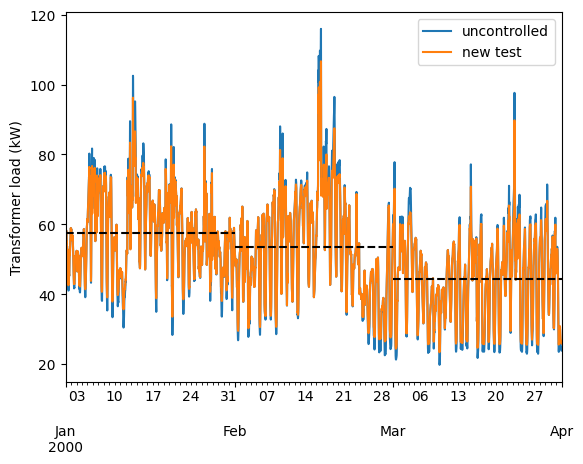

In [281]:
deltaStart = pd.Timedelta(days=0)
deltaEnd = pd.Timedelta(weeks=13)
jan_days = pd.Timedelta(days=31)
feb_days = pd.Timedelta(days=29)

node = 'N2'
start = data['uncontrolled'].index[0] + deltaStart
stop = start + deltaEnd

fig, ax = plt.subplots()
data['uncontrolled'][node].rolling(window=4).mean().loc[start:stop].plot(ax=ax)
data['power'][node].rolling(window=4).mean().loc[start:stop].plot(ax=ax)
data_range = [
    data['uncontrolled'][month_index[0]:month_index[1]][node],
    data['uncontrolled'][month_index[1]:month_index[2]][node],
    data['uncontrolled'][month_index[2]:month_index[3]][node]
]
ax.hlines(
    y=[data_range[0].mean(),
       data_range[1].mean(),
       data_range[2].mean()],
    xmin=[start,
          start+jan_days,
          start+jan_days+feb_days],
    xmax=[start+jan_days,
          start+jan_days+feb_days,
          stop], 
    linestyles='--', 
    colors='black'
)

ax.legend(['uncontrolled', 'new test'])
ax.set_ylabel('Transformer load (kW)')
ax.set_xlabel('')

plt.show()

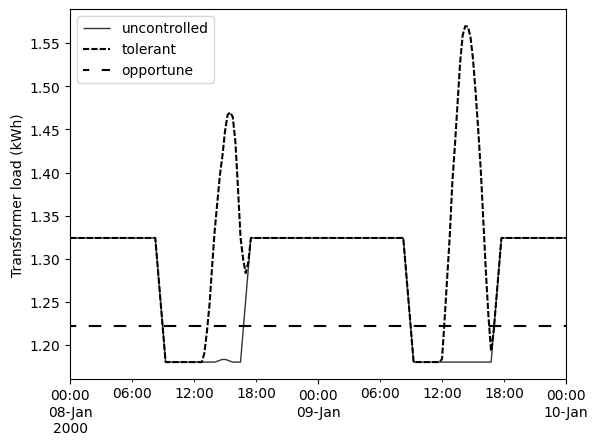

In [282]:
# Node load graph

deltaStart = pd.Timedelta(days=7)
deltaStart2 = pd.Timedelta(days=31+29+31+30+31+30+3) 
deltaEnd = pd.Timedelta(days=2)

node = 'N3'
start = data['uncontrolled'].index[0] + deltaStart
stop = start + deltaEnd

fig, ax = plt.subplots()
data['uncontrolled'][node].rolling(window=4).mean().loc[start:stop].plot(
    ax=ax,
    linestyle=(0, ()),
    linewidth=1,
    alpha=0.8,
    color='black'
)

data['power'][node].rolling(window=4).mean().loc[start:stop].plot(
    ax=ax,
    linestyle=(0, (3, 1)),
    linewidth=1.5,
    alpha=1,
    color='black'
)
'''
data['opportune'][node].rolling(window=4).mean().loc[start:stop].plot(
    ax=ax,
    linestyle=(0, (3, 1)),
    linewidth=1.5,
    alpha=1,
    color='gray'
)
'''

data_range = [
    data['uncontrolled'][month_index[0]:month_index[1]][node],
    data['uncontrolled'][month_index[6]:month_index[7]][node]
]
ax.hlines(
    y=[data_range[0].mean()],
    xmin=[start],
    xmax=[stop], 
    linestyles=(3, (6, 6)), 
    colors='black'
)


ax.legend(['uncontrolled', 'tolerant', 'opportune', 'average'])
ax.set_ylabel('Transformer load (kWh)')
ax.set_xlabel('')

plt.show()

6537.49
6272.13
6504.33


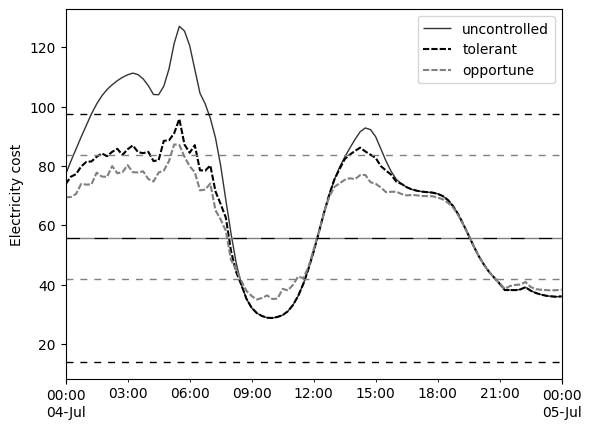

In [290]:
# Node cost graph

node = 'N2'
start = data['uncontrolled'].index[0] + deltaStart2
stop = start + deltaEnd

fig, ax = plt.subplots()
costs = {}
for key, value in data.items():
    costs[key] = data[key][node] * prices[key]

print(round(sum(costs['uncontrolled'])/100/4, 2))
print(round(sum(costs['tolerant'])/100/4, 2))
print(round(sum(costs['opportune'])/100/4, 2))

costs['uncontrolled'].rolling(window=4).mean().loc[start:stop].plot(
    ax=ax,
    linestyle=(0, ()),
    linewidth=1,
    alpha=0.8,
    color='black'
)

costs['tolerant'].rolling(window=4).mean().loc[start:stop].plot(
    ax=ax,
    linestyle=(0, (3, 1)),
    linewidth=1.5,
    alpha=1,
    color='black'
)

costs['opportune'].rolling(window=4).mean().loc[start:stop].plot(
    ax=ax,
    linestyle=(0, (3, 1)),
    linewidth=1.5,
    alpha=1,
    color='gray'
)


data_range = data['uncontrolled'][node].loc[start:stop]
data_mean = data_range.mean()

ax.hlines(
    y=[data_mean*2,
       data_mean*0.5,
       data_mean*3.5],
    xmin=start,
    xmax=stop,
    linestyles=[(0, (10, 10)),
                (0, (5, 5)),
                (0, (5, 5))],
    linewidth=1,
    colors='black'
)

ax.hlines(
    y=[data_mean*2,
       data_mean*1.5,
       data_mean*3.0],
    xmin=start,
    xmax=stop,
    linestyles=[(10, (10, 10)),
                (0, (5, 5)),
                (0, (5, 5))],
    linewidth=1,
    colors='gray'
)


ax.legend(['uncontrolled', 'tolerant', 'opportune'])
ax.set_ylabel('Electricity cost')
ax.set_xlabel('')

plt.show()

In [70]:
# Use different line styles rather than colors
# Change both to black
# Printed out versions
# (Run another with different parameters)
#
# Figure 1: winter (1 day)
# Figure 2: summer (1 day)
# Figure 3: bar chart?
# # aggregate demand per-hour for the whole year --> 24 bars
#print(data['power']['N2'].iloc[0])
#print(data['power'].index[0:96])

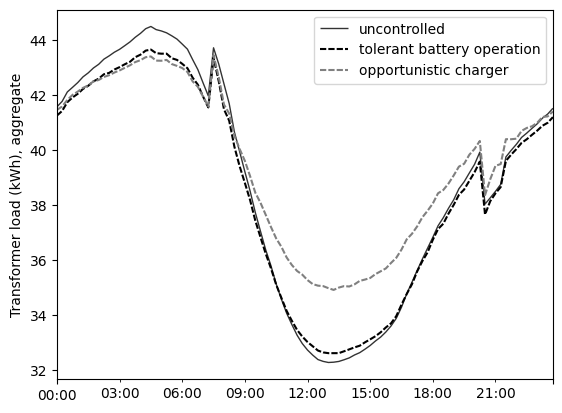

In [286]:
deltaStart = pd.Timedelta(days=0)
deltaEnd = pd.Timedelta(days=1)

node = 'N2'
start = data['uncontrolled'].index[0] + deltaStart
stop = start + deltaEnd

new_frame = {
    'uncontrolled': [
        times.mean() for times in [ data['uncontrolled'][node].iloc[i::96] for i in range(96) ]
    ],
    'tolerant': [
        times.mean() for times in [ data['tolerant'][node].iloc[i::96] for i in range(96) ]
    ],
    'opportune': [
        times.mean() for times in [ data['opportune'][node].iloc[i::96] for i in range(96) ]
    ]
}
aggregated = pd.DataFrame(new_frame, index=pd.to_datetime(data['uncontrolled'].index[0:96]).copy())

fig, ax = plt.subplots()

aggregated['uncontrolled'].loc[start:stop].plot(
    ax=ax,
    linestyle=(0, ()),
    linewidth=1,
    alpha=0.8,
    color='black'
)

aggregated['tolerant'].loc[start:stop].plot(
    ax=ax,
    linestyle=(0, (3, 1)),
    linewidth=1.5,
    #marker='o',
    #markersize=3,
    alpha=1,
    color='black'
)

aggregated['opportune'].loc[start:stop].plot(
    ax=ax,
    linestyle=(0, (3, 1)),
    linewidth=1.5,
    #marker='o',
    #markersize=3,
    alpha=1,
    color='gray'
)

ax.legend(['uncontrolled', 'tolerant battery operation', 'opportunistic charger'])
ax.set_ylabel('Transformer load (kWh), aggregate')
ax.set_xlabel('')
[locs, labels] = plt.xticks()
labels[0].set_text('00:00')
plt.xticks(locs, labels)

plt.show()

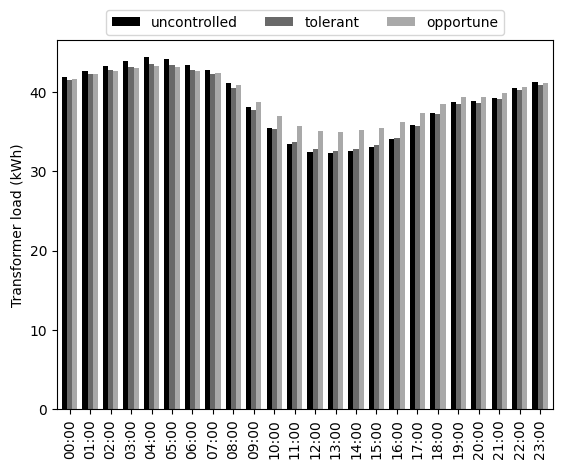

In [289]:
deltaStart = pd.Timedelta(days=0)
deltaEnd = pd.Timedelta(days=1)

node = 'N2'
start = data['uncontrolled'].index[0] + deltaStart
stop = start + deltaEnd

hourly = {}
for key in new_frame:
    hourly[key] = [ sum(times)/4 for times in [ new_frame[key][4*i:4*(i+1)] for i in range(24)] ]
hourly_agg = pd.DataFrame(hourly, index=aggregated.index[0::4].copy())

fig, ax = plt.subplots()

'''
hourly_agg['uncontrolled'].loc[start:stop].plot.bar(
    ax=ax,
    #linestyle=(0, ()),
    #linewidth=1,
    #alpha=0.8,
    color='black',
    width=0.75
)
'''

hourly_agg.plot.bar(
    ax=ax,
    #linestyle=(0, (3, 1)),
    #linewidth=1.5,
    #marker='o',
    #markersize=3,
    #alpha=1,
    color=['black', 'dimgray', 'darkgray'],
    width=0.75
)

ax.legend(['uncontrolled', 'tolerant', 'opportune'], loc='upper center', bbox_to_anchor=(0.5,1.1), ncol=3)
ax.set_ylabel('Transformer load (kWh)')
ax.set_xlabel('')
[locs, labels] = plt.xticks()
for i in range(24):
    labels[i].set_text(f'{i:02d}:00')

plt.xticks(locs, labels)

plt.show()

In [ ]:
deltaStart = pd.Timedelta(days=0)
deltaEnd = pd.Timedelta(days=1)

node = 'N2'
start = data['uncontrolled'].index[0] + deltaStart
stop = start + deltaEnd

hourly = {}
for key in new_frame:
    hourly[key] = [ sum(times)/4 for times in [ new_frame[key][4*i:4*(i+1)] for i in range(24)] ]
hourly_agg = pd.DataFrame(hourly, index=aggregated.index[0::4].copy())

fig, ax = plt.subplots()

'''
hourly_agg['uncontrolled'].loc[start:stop].plot.bar(
    ax=ax,
    #linestyle=(0, ()),
    #linewidth=1,
    #alpha=0.8,
    color='black',
    width=0.75
)
'''

hourly_agg.plot.bar(
    ax=ax,
    #linestyle=(0, (3, 1)),
    #linewidth=1.5,
    #marker='o',
    #markersize=3,
    #alpha=1,
    color=['black', 'dimgray', 'darkgray'],
    width=0.75
)

ax.legend(['uncontrolled', 'tolerant', 'opportune'], loc='upper center', bbox_to_anchor=(0.5,1.1), ncol=3)
ax.set_ylabel('Transformer load (kWh)')
ax.set_xlabel('')
[locs, labels] = plt.xticks()
for i in range(24):
    labels[i].set_text(f'{i:02d}:00')

plt.xticks(locs, labels)

plt.show()

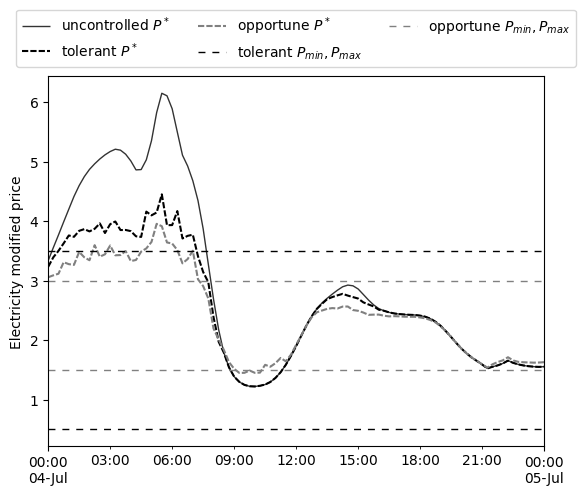

In [313]:
# P* and Pmin Pmax graph
deltaStart = pd.Timedelta(days=7)
deltaStart2 = pd.Timedelta(days=31+29+31+30+31+30+3) 
deltaEnd = pd.Timedelta(days=1)

node = 'N6'
start = data['uncontrolled'].index[0] + deltaStart2
stop = start + deltaEnd

fig, ax = plt.subplots()
costs = {}
for key, value in data.items():
    costs[key] = data[key][node] * prices[key] / (means[node][month_index[6]]/1e3)


costs['uncontrolled'].rolling(window=4).mean().loc[start:stop].plot(
    ax=ax,
    linestyle=(0, ()),
    linewidth=1,
    alpha=0.8,
    color='black'
)

costs['tolerant'].rolling(window=4).mean().loc[start:stop].plot(
    ax=ax,
    linestyle=(0, (3, 1)),
    linewidth=1.5,
    alpha=1,
    color='black'
)

costs['opportune'].rolling(window=4).mean().loc[start:stop].plot(
    ax=ax,
    linestyle=(0, (3, 1)),
    linewidth=1.5,
    alpha=1,
    color='gray'
)


#data_range = data['uncontrolled'][node].loc[start:stop]
#data_mean = data_range.mean()

ax.hlines(
    y=[0.5,
       3.5],
    xmin=start,
    xmax=stop,
    linestyles=[(0, (5, 5)),
                (0, (5, 5))],
    linewidth=1,
    colors='black'
)

ax.hlines(
    y=[1.5,
       3.0],
    xmin=start,
    xmax=stop,
    linestyles=[(0, (5, 5)),
                (0, (5, 5))],
    linewidth=1,
    colors='gray'
)


ax.legend([r'uncontrolled $P^*$',
           r'tolerant $P^*$',
           r'opportune $P^*$',
           r'tolerant $P_{min}, P_{max}$',
           r'opportune $P_{min}, P_{max}$'],
           loc='upper center',
           bbox_to_anchor=(0.5,1.2),
           ncol=3)
ax.set_ylabel('Electricity modified price')
ax.set_xlabel('')

plt.show()

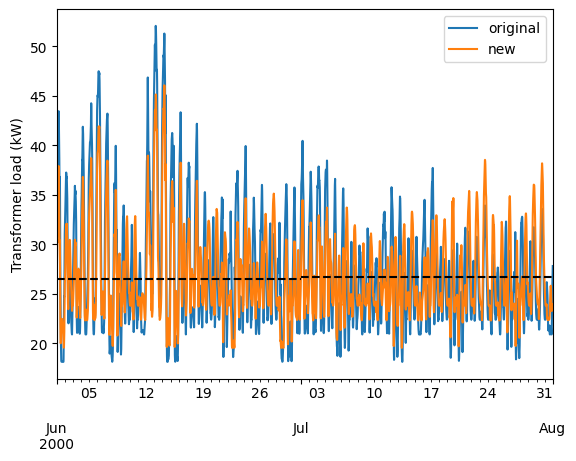

In [15]:
deltaStart = pd.Timedelta(days=31+29+31+30+31)
deltaEnd = pd.Timedelta(days=30+31)
jun_days = pd.Timedelta(days=30)

node = 'N2'
start = data['power'].index[0] + deltaStart
stop = start + deltaEnd

fig, ax = plt.subplots()
#data['power'][node].loc[start:stop].plot(ax=ax)
data['uncontrolled'][node].rolling(window=4).mean().loc[start:stop].plot(ax=ax)
data['power'][node].rolling(window=4).mean().loc[start:stop].plot(ax=ax)
#data['power_old'][node].rolling(window=4).mean().loc[start:stop].plot(ax=ax)
data_range = [
    data['power'][month_index[5]:month_index[6]][node],
    data['power'][month_index[6]:month_index[7]][node]
]
ax.hlines(
    y=[data_range[0].mean(),
       data_range[1].mean()],
    xmin=[start,
          start+jun_days],
    xmax=[start+jun_days,
          stop], 
    linestyles='--', 
    colors='black'
)


#ax.hlines(
#    y=62992/1e3,
#    xmin=start, 
#    xmax=stop, 
#    linestyles='--', 
#    colors='darkred'
#)
#ax.hlines(
#    y=[(62992-13291)/1e3, (62992+13291)/1e3],
#    xmin=start, 
#    xmax=stop, 
#    linestyles='-.', 
#    colors='darkred'
#)
#data['power']['price'].rolling(window=24*4*3).mean().loc[start:stop].plot(ax=ax)
#data['power_old'][node].rolling(window=24*4*3).mean().loc[start:stop].plot(ax=ax)
#(data['power_old'][node].loc[start:stop]-data['uncontrolled'][node].loc[start:stop]).rolling(window=4).mean().plot(ax=ax)
#(data['power'][node].loc[start:stop]-data['uncontrolled'][node].loc[start:stop]).rolling(window=4).mean().plot(ax=ax)
#print( (data['power_old'][node].loc[start:stop]-data['uncontrolled'][node].loc[start:stop]).sum() )
ax.legend(['original', 'new'])
ax.set_ylabel('Transformer load (kW)')
ax.set_xlabel('')

plt.show()

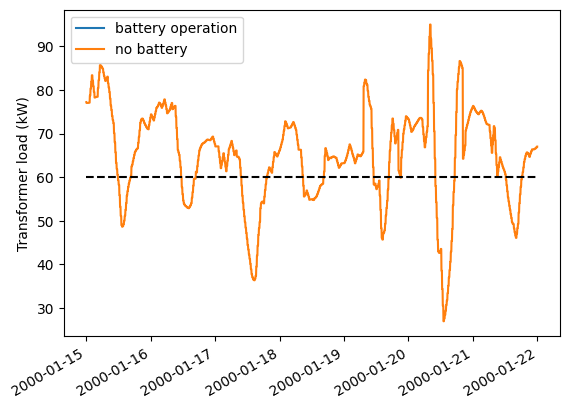

In [ ]:
deltaStart = pd.Timedelta(days=14)
deltaEnd = pd.Timedelta(days=7)

node = 'N2'
start = data['power'].index[0] + deltaStart
stop = start + deltaEnd

fig, ax = plt.subplots()
data['power'].loc[start:stop][node].plot(ax=ax)
data['uncontrolled'].loc[start:stop][node].plot(ax=ax)
ax.hlines(
    y=data['uncontrolled'][node].mean(),
    xmin=start, 
    xmax=stop, 
    linestyles='--', 
    colors='black'
)
ax.legend(['battery operation', 'no battery'])
ax.set_ylabel('Transformer load (kW)')
ax.set_xlabel('')

plt.show()

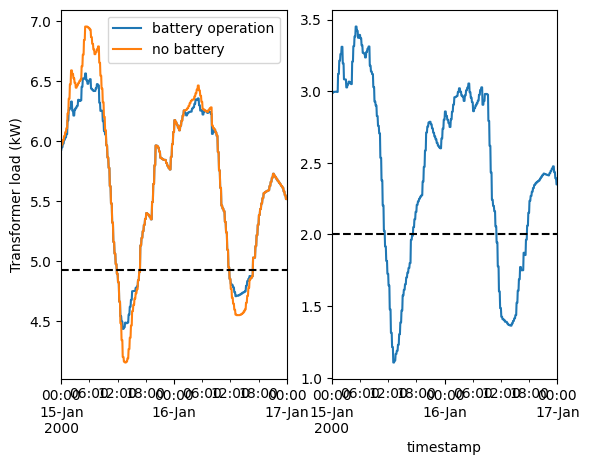

In [234]:
deltaStart = pd.Timedelta(days=14)
deltaEnd = pd.Timedelta(days=2)

node = 'N14'
start = data['power'].index[0] + deltaStart
stop = start + deltaEnd

fig, (ax1, ax2) = plt.subplots(1, 2)
data['power'].loc[start:stop][node].plot(ax=ax1)
data['uncontrolled'].loc[start:stop][node].plot(ax=ax1)
ax1.hlines(
    y=data['uncontrolled'][node].mean(), 
    xmin=start, 
    xmax=stop, 
    linestyles='--', 
    colors='black'
)
ax1.legend(['battery operation', 'no battery'])
ax1.set_ylabel('Transformer load (kW)')
ax1.set_xlabel('')

data['power']['price'].loc[start:stop].plot(ax=ax2)
ax2.hlines(
    y=2, 
    xmin=start, 
    xmax=stop, 
    linestyles='--',
    colors='black'
)

plt.show()

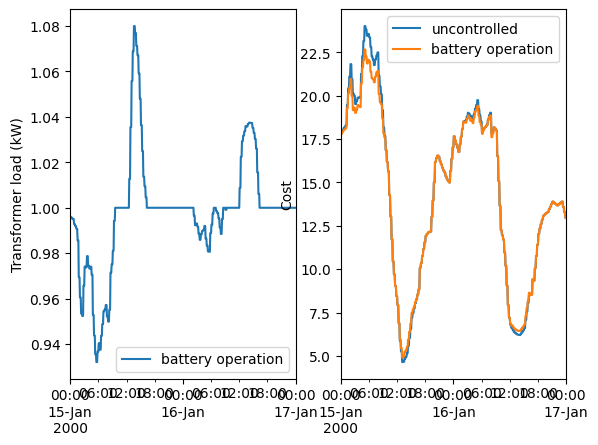

In [236]:
deltaStart = pd.Timedelta(days=14)
deltaEnd = pd.Timedelta(days=2)

node = 'N14'
start = data['power'].index[0] + deltaStart
stop = start + deltaEnd

fig, (ax1, ax2) = plt.subplots(1, 2)

compare = data['power'].loc[start:stop][node]/data['uncontrolled'].loc[start:stop][node]
compare.plot(ax=ax1)

cost_base = data['uncontrolled'].loc[start:stop][node]*data['power'].loc[start:stop]['price']
cost_test = data['power'].loc[start:stop][node]*data['power'].loc[start:stop]['price']
cost_base.plot(ax=ax2)
cost_test.plot(ax=ax2)

ax1.legend(['battery operation'])
ax1.set_ylabel('Transformer load (kW)')
ax1.set_xlabel('')

ax2.legend(['uncontrolled','battery operation'])
ax2.set_ylabel('Cost')
ax2.set_xlabel('')

plt.show()

### Node voltages. The closer to 120 V, the better; the sag seen here is due to the loads being oversized for the circuit. This is more of an issue during winter months for buildings with electric heating. Selecting smaller RBSA cases will likely give better results. Imaginary parts also available in `gridlab-d/Volt_log.csv`.

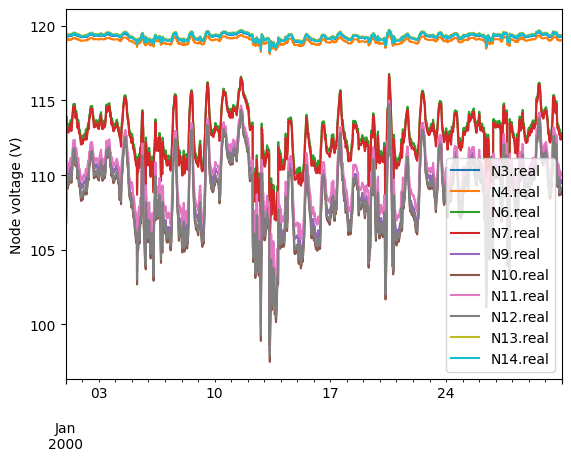

In [69]:
v = pd.read_csv('gridlab-d/Volt_log.csv', skiprows = 7, index_col = 0)
v.index.name = v.index.name.replace('# ', '')
v.columns = v.columns.str.replace(':measured_voltage_1', '')
v.index = pd.DatetimeIndex(v.index.str.replace(' PST', ''))

fig, ax = plt.subplots()
v[[column for column in v.columns if column.endswith('.real')]].plot(ax=ax)
ax.set_ylabel('Node voltage (V)')
ax.set_xlabel('')
plt.show()

### Real power losses, computed by subtracting the sum of the building nodes' consumption from the transformer consumption. For now, this data scales with demand, but that may change as more detailed ZIP coefficients and power factors are added.

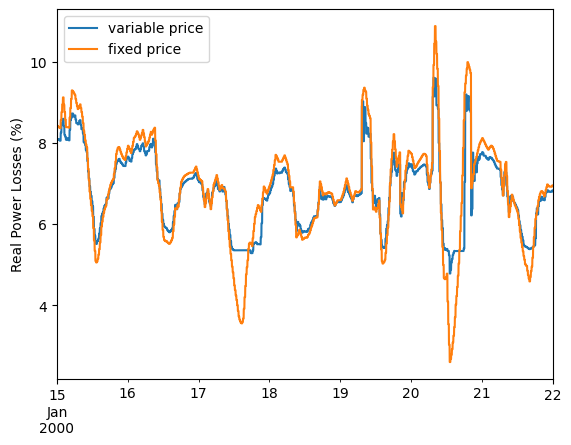

In [6]:
fig, ax = plt.subplots()
for df in [power, uncontrolled]:
    df = df.loc[start:stop]
    (100*(df.N2 - df.drop(columns='N2').sum(axis='columns'))/df.N2).plot(ax=ax)
ax.set_ylabel('Real Power Losses (%)')
ax.legend(['variable price', 'fixed price'])
ax.set_xlabel('')
plt.show()